In [1]:
import glob

from auditor import *

In [2]:
treatment_names = ['change_gender', 'change_race', 'change_gender_and_race']

score_name = "Toxicity_score"
score_names = [score_name]
# In future work also look at other scores that perspective returns -- add names to score_names list

primary_key = 'ID'

groups_of_interest ={"Text_length":['short <100'],
                     "Sentiment_polarity":['Pretty positive', 'Pretty negative']}

In [3]:
# Loading the text information results from nlp profiler
text_info_df = pd.read_csv("./Proper_noun_data/Proper_noun_text_info.csv")
text_info_df.columns

Index(['Unnamed: 0', 'ID', 'Text_length', 'Sentiment_polarity'], dtype='object')

In [4]:
# Loading Perspective's scores for each text
scores_df = pd.read_csv("./Proper_noun_data/Proper_noun_toxicity_scores.csv")
scores_df.columns

Index(['Unnamed: 0', 'Unnamed: 0.1', 'score', 'Emily_score', 'Greg_score',
       'Jamal_score', 'Lakisha_score'],
      dtype='object')

In [5]:
scores_df.drop_duplicates(subset=['Unnamed: 0.1'], inplace=True)
text_info_df.drop_duplicates(subset=['ID'], inplace=True)

text_info_df.shape, scores_df.shape

((1428, 4), (1427, 7))

In [6]:
# Only using those rows whose ID's match (ie. texts for which we have both scores and profiler results)

res_i = scores_df['Unnamed: 0.1'].values
demo_i = text_info_df['ID'].values

ID_list = list(set.intersection(set(res_i), set(demo_i) ))
print(len(ID_list))

scores_df = scores_df[scores_df['Unnamed: 0.1'].isin(ID_list)]
text_info_df = text_info_df[text_info_df['ID'].isin(ID_list)]



text_info_df.shape, scores_df.shape

1427


((1427, 4), (1427, 7))

In [7]:
temp = scores_df[['Unnamed: 0.1', 'Greg_score']]
control_scores = temp.rename(columns={'Unnamed: 0.1': primary_key, 'Greg_score': score_name})
control_scores.set_index(primary_key, inplace=True)

control_scores.shape

(1427, 1)

In [8]:
col_names = ['Emily_score', 'Jamal_score', 'Lakisha_score']

In [9]:
treatment_scores = {}

In [10]:
for i in range(len(treatment_names)):
    temp = scores_df[['Unnamed: 0.1', col_names[i]]]
    treatment_scores[treatment_names[i]] = temp.rename(columns={'Unnamed: 0.1': primary_key, col_names[i]: score_name})
    treatment_scores[treatment_names[i]].set_index(primary_key, inplace=True)

In [11]:
perspective_audit = Auditor(score_names, primary_key, control_scores, 
                          treatment_scores, text_info_df, groups_of_interest)

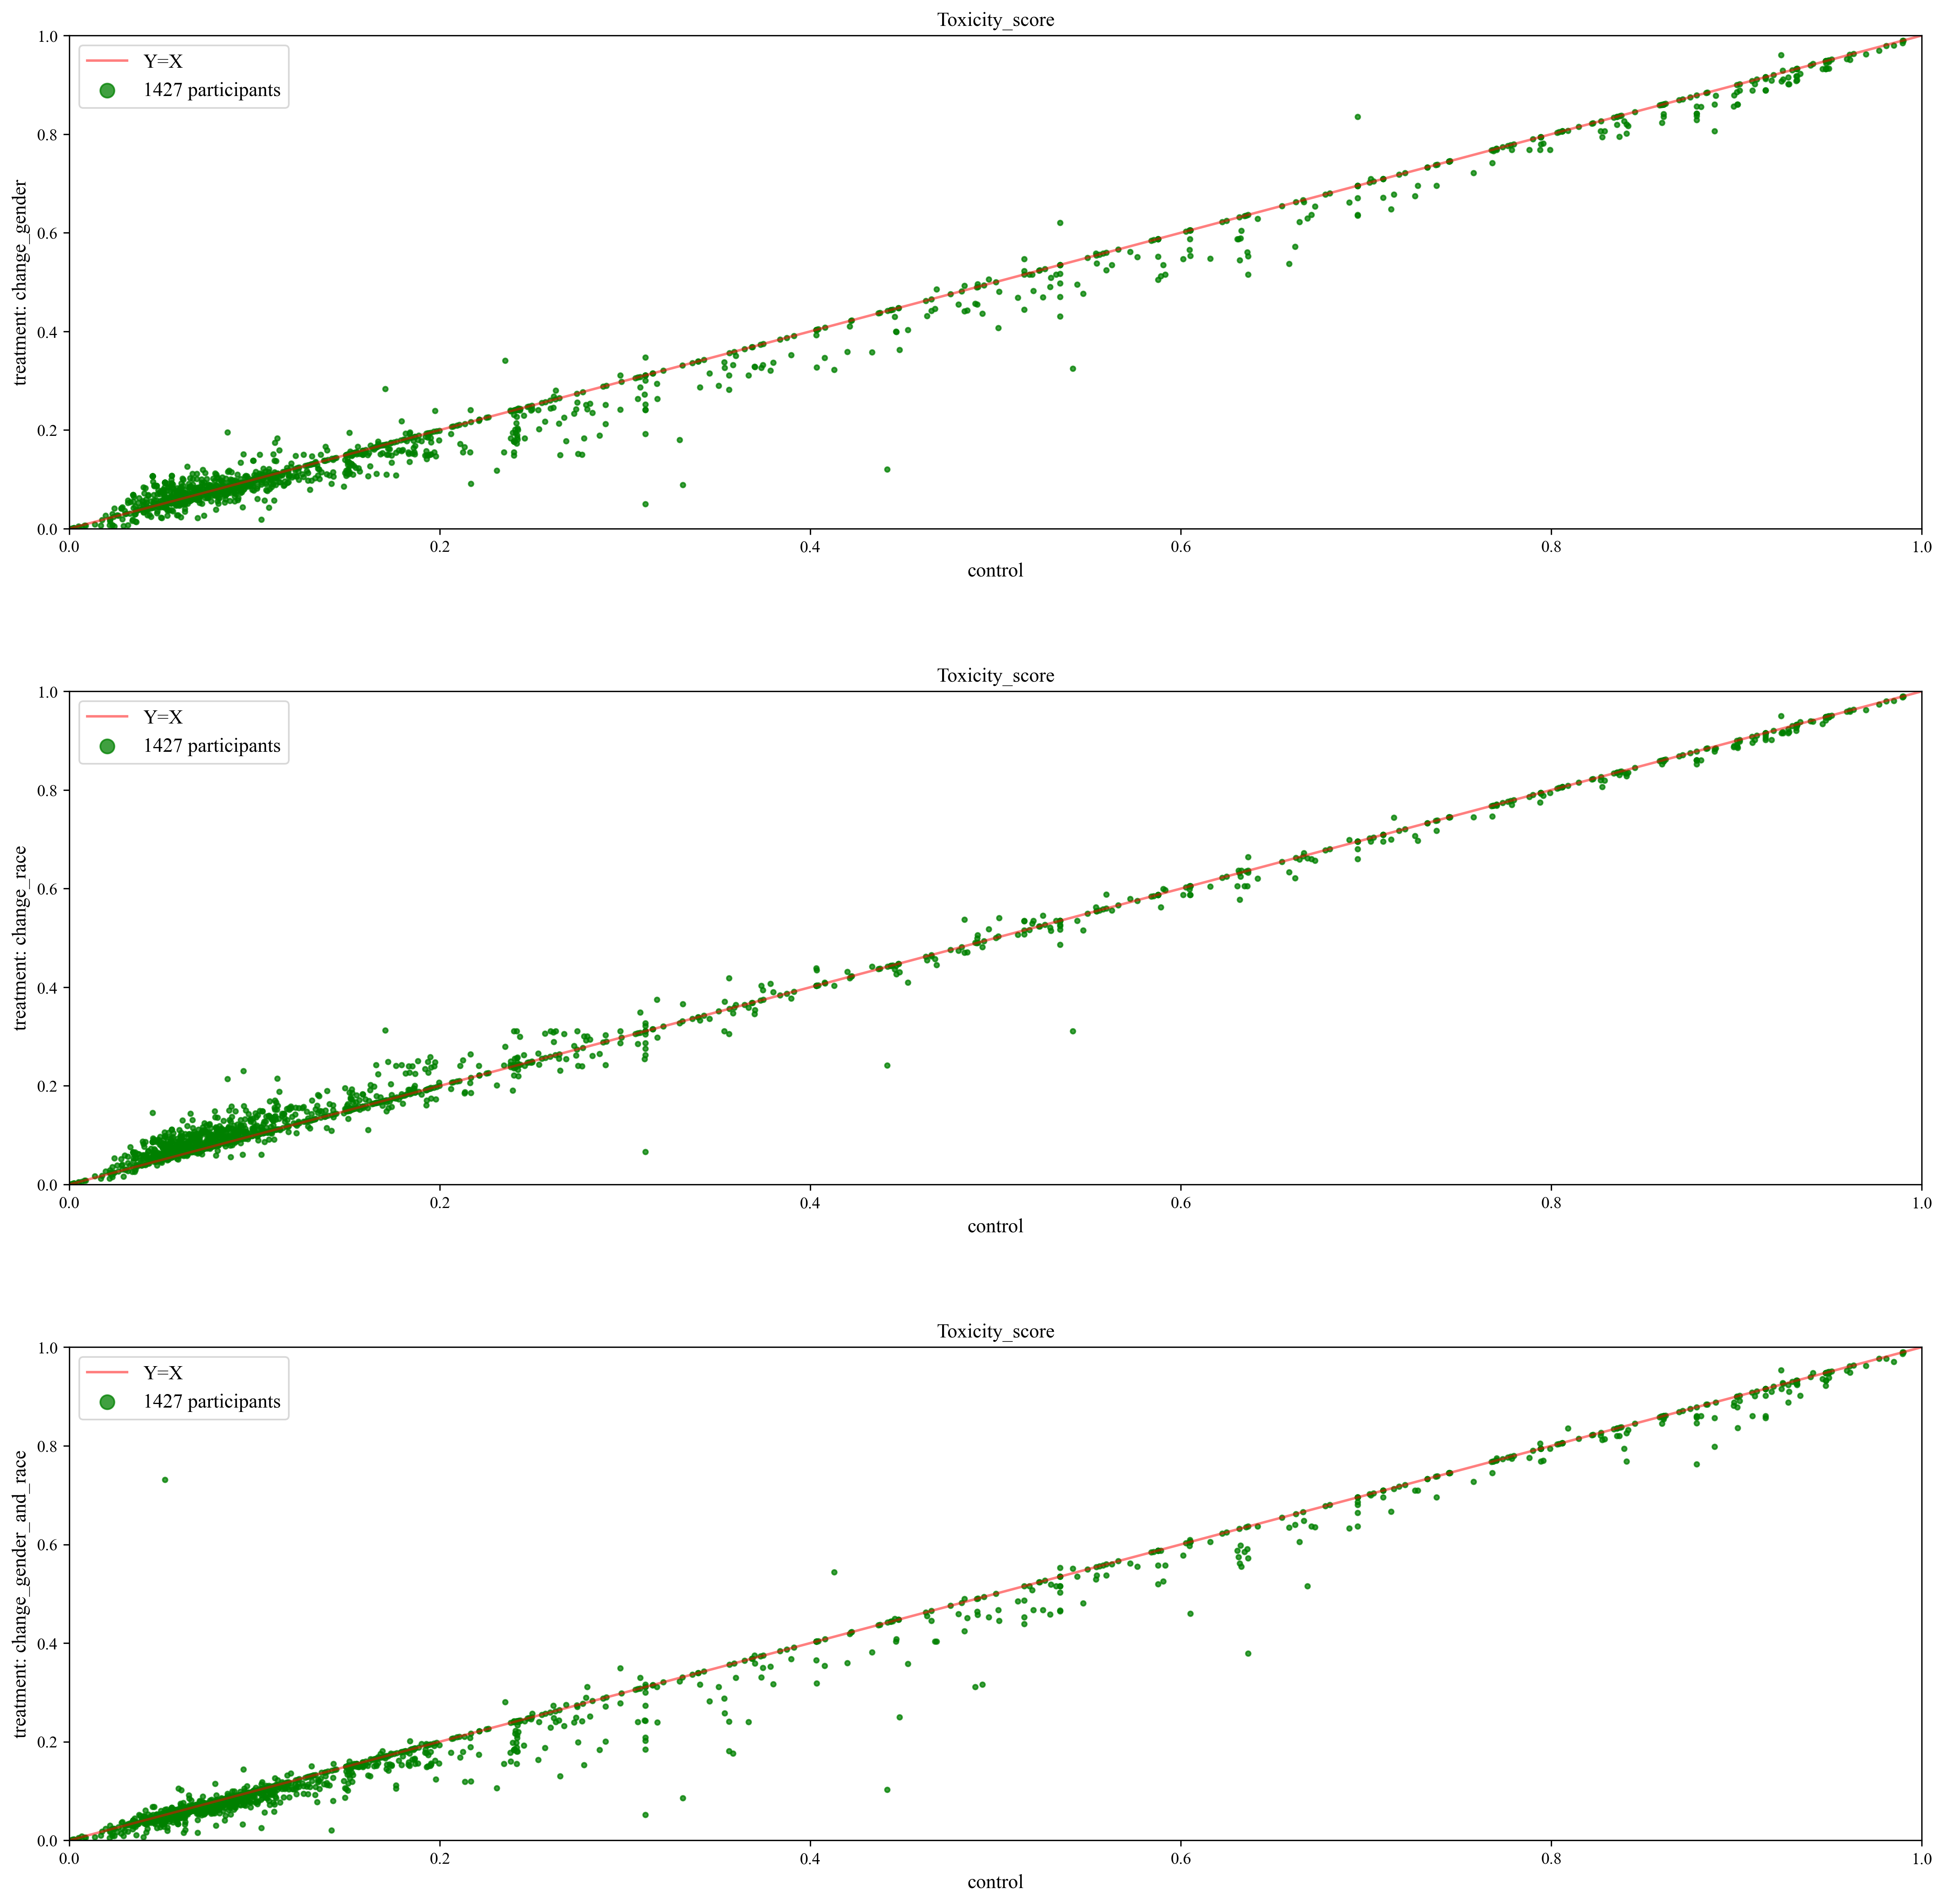

In [12]:
perspective_audit.visualize_scores(axislim=1)

In [13]:
tv = perspective_audit.compute_total_variation()
tv

Toxicity_score
change_gender          overall__                          mean        0.016300
                                                          std         0.025254
                       Text_length_short <100             mean        0.018063
                                                          std         0.026773
                       Text_length_others                 mean        0.015417
                                                          std         0.024425
                       Sentiment_polarity_Pretty positive mean        0.017053
                                                          std         0.028206
                       Sentiment_polarity_Pretty negative mean        0.014485
                                                          std         0.022107
                       Sentiment_polarity_others          mean        0.016527
                                                          std         0.022258
change_race            overall__                          mean        0.014069
                                                          std         0.019817
                       Text_length_short <100             mean        0.015214
                                                          std         0.021095
                       Text_length_others                 mean        0.013497
                                                          std         0.019131
                       Sentiment_polarity_Pretty positive mean        0.014916
                                                          std         0.020607
                       Sentiment_polarity_Pretty negative mean        0.012523
                                                          std         0.019803
                       Sentiment_polarity_others          mean        0.013923
                                                          std         0.018398
change_gender_and_race overall__                          mean        0.013982
                                                          std         0.031703
                       Text_length_short <100             mean        0.016600
                                                          std         0.041473
                       Text_length_others                 mean        0.012671
                                                          std         0.025367
                       Sentiment_polarity_Pretty positive mean        0.014400
                                                          std         0.030518
                       Sentiment_polarity_Pretty negative mean        0.012399
                                                          std         0.022100
                       Sentiment_polarity_others          mean        0.014580
                                                          std         0.039414

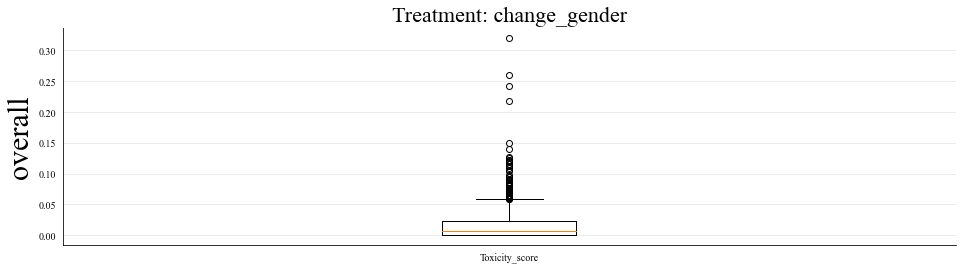

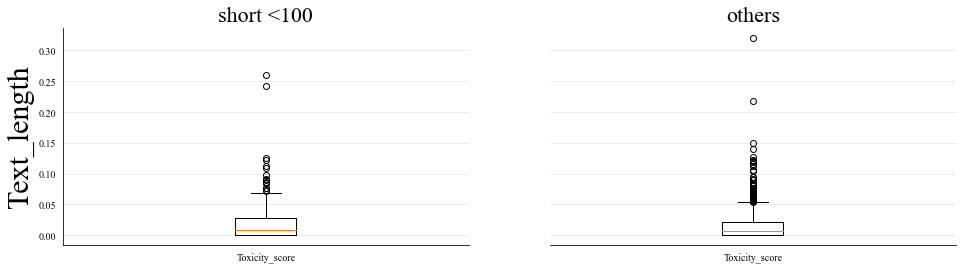

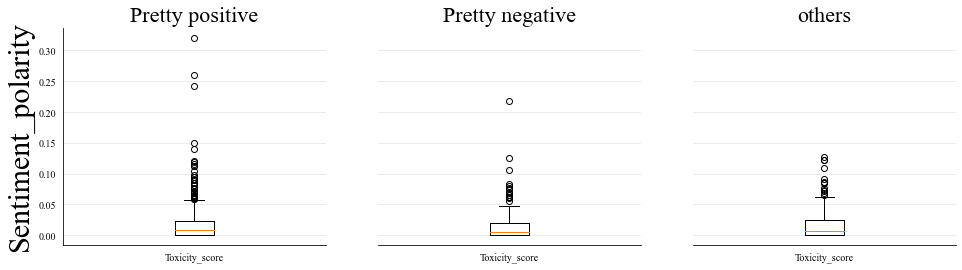

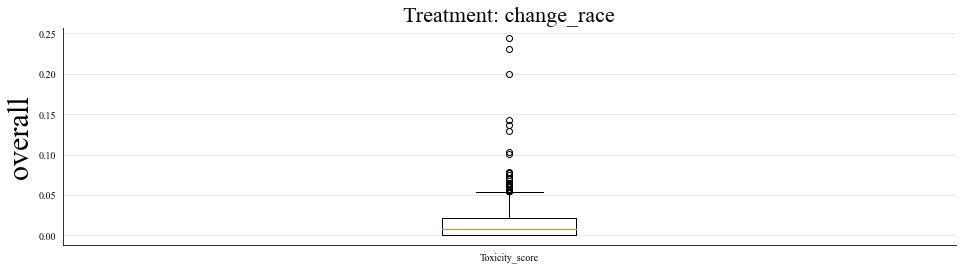

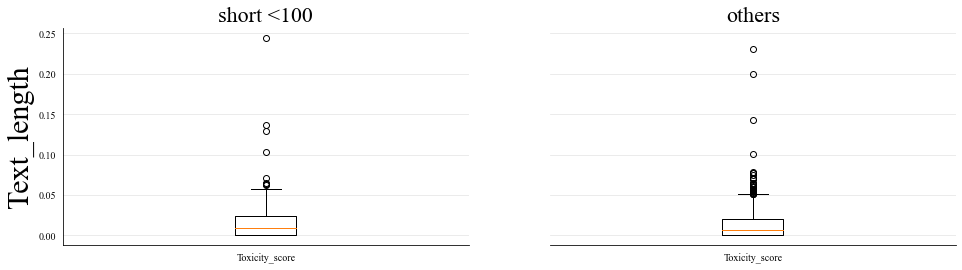

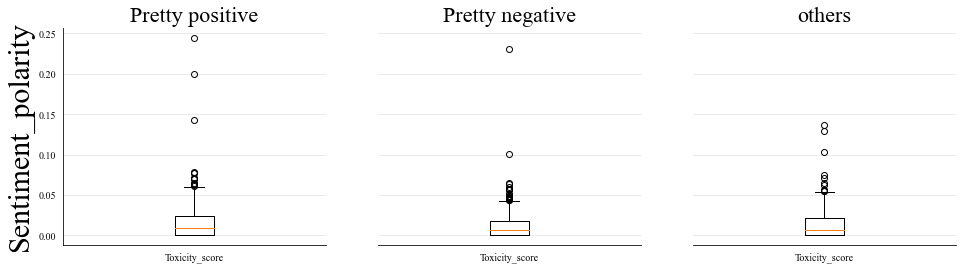

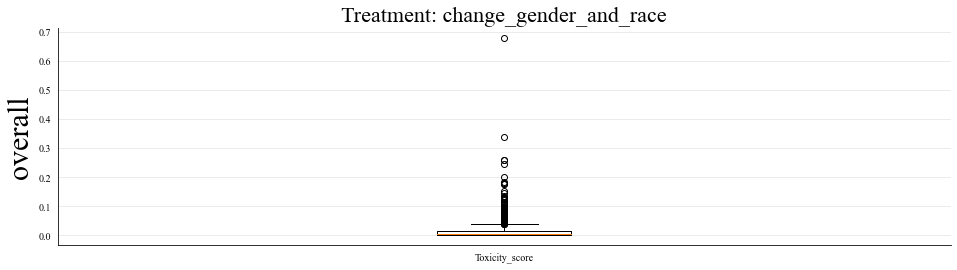

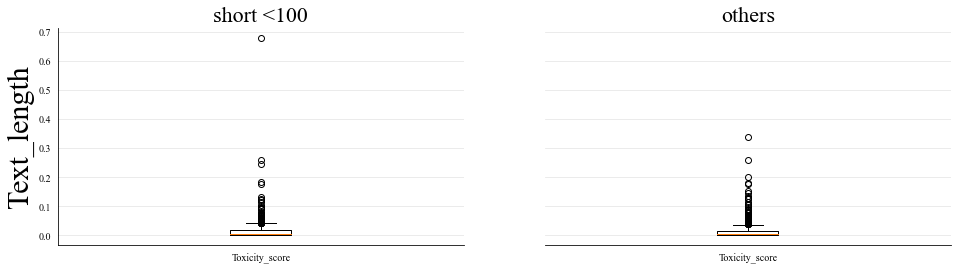

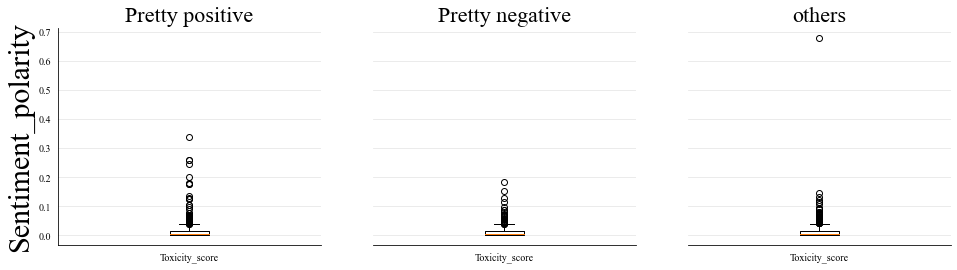

In [14]:
perspective_audit.visualize_total_variation()

In [15]:
def get_corr_results(perspective_audit, test, test_name, cutoff_low, cutoff_high):
    low = test_name+" >"+str(cutoff_low)
    high = test_name+" >"+str(cutoff_high)
    
    spearman_ = perspective_audit.compute_statistic(test=test)
    spearman_corr = spearman_.loc[[i for i in spearman_.index if 'correlation' in i]]
    spearman_corr.rename(columns={score_name:test_name}, inplace=True)

    spearman_corr[low] = [i>cutoff_low for i in spearman_corr[test_name].values]
    spearman_corr[high] = [i>cutoff_high for i in spearman_corr[test_name].values]
    return spearman_corr

In [16]:
spearman_res = get_corr_results(perspective_audit, spearman, "spearman", 0.9, 0.95)
pearsons_res = get_corr_results(perspective_audit, pearsons, "pearsons", 0.9, 0.95)
kendall_tau_res = get_corr_results(perspective_audit, kendall_tau, "kendall_tau", 0.9, 0.95)

In [17]:
correlation_tests = pd.concat([spearman_res, pearsons_res, kendall_tau_res], axis=1)
correlation_tests

spearman  \
change_gender          overall__                          correlation  0.947051   
                       Text_length_short <100             correlation  0.929493   
                       Text_length_others                 correlation  0.956042   
                       Sentiment_polarity_Pretty positive correlation  0.942153   
                       Sentiment_polarity_Pretty negative correlation  0.950411   
                       Sentiment_polarity_others          correlation  0.949716   
change_race            overall__                          correlation  0.961520   
                       Text_length_short <100             correlation  0.954584   
                       Text_length_others                 correlation  0.965418   
                       Sentiment_polarity_Pretty positive correlation  0.957330   
                       Sentiment_polarity_Pretty negative correlation  0.958270   
                       Sentiment_polarity_others          correlation  0.968395   
change_gender_and_race overall__                          correlation  0.977062   
                       Text_length_short <100             correlation  0.962360   
                       Text_length_others                 correlation  0.984090   
                       Sentiment_polarity_Pretty positive correlation  0.975859   
                       Sentiment_polarity_Pretty negative correlation  0.982874   
                       Sentiment_polarity_others          correlation  0.972887   

                                                                       spearman >0.9  \
change_gender          overall__                          correlation           True   
                       Text_length_short <100             correlation           True   
                       Text_length_others                 correlation           True   
                       Sentiment_polarity_Pretty positive correlation           True   
                       Sentiment_polarity_Pretty negative correlation           True   
                       Sentiment_polarity_others          correlation           True   
change_race            overall__                          correlation           True   
                       Text_length_short <100             correlation           True   
                       Text_length_others                 correlation           True   
                       Sentiment_polarity_Pretty positive correlation           True   
                       Sentiment_polarity_Pretty negative correlation           True   
                       Sentiment_polarity_others          correlation           True   
change_gender_and_race overall__                          correlation           True   
                       Text_length_short <100             correlation           True   
                       Text_length_others                 correlation           True   
                       Sentiment_polarity_Pretty positive correlation           True   
                       Sentiment_polarity_Pretty negative correlation           True   
                       Sentiment_polarity_others          correlation           True   

                                                                       spearman >0.95  \
change_gender          overall__                          correlation           False   
                       Text_length_short <100             correlation           False   
                       Text_length_others                 correlation            True   
                       Sentiment_polarity_Pretty positive correlation           False   
                       Sentiment_polarity_Pretty negative correlation            True   
                       Sentiment_polarity_others          correlation           False   
change_race            overall__                          correlation            True   
                       Text_length_short <100             correlation            True   
                   

In [18]:
def test_statistic_results(perspective_audit, test, test_name, correction, alpha_threshold):
    test_ = perspective_audit.compute_statistic(test=test)
    pvals = test_.loc[[i for i in test_.index if 'p_value' in i]]
    corrected = perspective_audit.multiple_hypothesis_correction(pvals, alpha = alpha_threshold, method=correction)
    res = corrected[perspective_audit.score_names] > alpha_threshold
    res.rename(columns={score_name:test_name}, inplace=True)
    return res

In [19]:
wilcoxon_res = test_statistic_results(perspective_audit, wilcoxon, "wilcoxon", 'fdr_bh', 0.05)
student_t_res = test_statistic_results(perspective_audit, student_t, "student_t", 'fdr_bh', 0.05)
paired_student_t_res = test_statistic_results(perspective_audit, paired_student_t, "paired_student_t", 'fdr_bh', 0.05)
mann_whitney_u_res = test_statistic_results(perspective_audit, mann_whitney_u, "mann_whitney_u", 'fdr_bh', 0.05)
kruskal_wallis_h = test_statistic_results(perspective_audit, kruskal_wallis_h, "kruskal_wallis_h", 'fdr_bh', 0.05)

In [20]:
statistical_tests = pd.concat([wilcoxon_res, student_t_res, paired_student_t_res, mann_whitney_u_res, kruskal_wallis_h], axis=1)
statistical_tests

wilcoxon  \
change_gender          overall__                          p_value     False   
                       Text_length_short <100             p_value     False   
                       Text_length_others                 p_value     False   
                       Sentiment_polarity_Pretty positive p_value     False   
                       Sentiment_polarity_Pretty negative p_value     False   
                       Sentiment_polarity_others          p_value     False   
change_race            overall__                          p_value     False   
                       Text_length_short <100             p_value     False   
                       Text_length_others                 p_value     False   
                       Sentiment_polarity_Pretty positive p_value     False   
                       Sentiment_polarity_Pretty negative p_value     False   
                       Sentiment_polarity_others          p_value     False   
change_gender_and_race overall__                          p_value     False   
                       Text_length_short <100             p_value     False   
                       Text_length_others                 p_value     False   
                       Sentiment_polarity_Pretty positive p_value     False   
                       Sentiment_polarity_Pretty negative p_value     False   
                       Sentiment_polarity_others          p_value     False   

                                                                   student_t  \
change_gender          overall__                          p_value       True   
                       Text_length_short <100             p_value       True   
                       Text_length_others                 p_value       True   
                       Sentiment_polarity_Pretty positive p_value       True   
                       Sentiment_polarity_Pretty negative p_value       True   
                       Sentiment_polarity_others          p_value       True   
change_race            overall__                          p_value       True   
                       Text_length_short <100             p_value       True   
                       Text_length_others                 p_value       True   
                       Sentiment_polarity_Pretty positive p_value       True   
                       Sentiment_polarity_Pretty negative p_value       True   
                       Sentiment_polarity_others          p_value       True   
change_gender_and_race overall__                          p_value       True   
                       Text_length_short <100             p_value       True   
                       Text_length_others                 p_value       True   
                       Sentiment_polarity_Pretty positive p_value       True   
                       Sentiment_polarity_Pretty negative p_value       True   
                       Sentiment_polarity_others          p_value       True   

                                                                   paired_student_t  \
change_gender          overall__                          p_value             False   
                       Text_length_short <100             p_value             False   
                       Text_length_others                 p_value             False   
                       Sentiment_polarity_Pretty positive p_value             False   
                       Sentiment_polarity_Pretty negative p_value             False   
                       Sentiment_polarity_others          p_value             False   
change_race            overall__                          p_value             False   
                       Text_length_short <100             p_value             False   
                       Text_length_others                 p_value             False   
                       Sentiment_polarity_Pretty positive p_value             False   
                       Sentiment_polarity_Pretty negative p_value             False   
